In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [3]:
qb_df = pd.read_csv('qb_fantasy.csv')
qb_df

,Full Name,Position,Team,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
0,A.J. McCarron,QB,-,5.24,31.7,21,-,8.2,-,1.3,...,2,-,-,0,-,0,0,1,0,-
1,Aaron Rodgers,QB,Green Bay Packers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,...,16,16,2,1,4,0,2,1,3,3
2,Alex Smith,QB,-,1.01,38.1,19.3,15.1,17.1,15.2,20,...,8,-,1,2,5,1,1,-,0,-
3,Alex Tanney,QB,-,Undrafted,34.6,-,-,8,-,-,...,-,-,-,0,-,-,-,0,-,-
4,Andrew Luck,QB,-,1.01,32.7,20,23,20.1,21.1,-,...,-,-,3,0,2,-,0,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,QB,Baltimore Ravens,Undrafted,24.3,21.6,-,-,-,-,...,2,7,-,-,-,-,-,-,0,2
171,Tyrod Taylor,QB,New York Giants,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,...,2,6,0,4,6,4,1,0,0,3
172,Will Grier,QB,Dallas Cowboys,3.36,27.2,22.4,-,-,-,-,...,-,-,-,-,-,-,-,0,-,-
173,Zach Mettenberger,QB,-,6.02,30.9,22.1,11.1,7,-,-,...,-,-,0,1,-,-,-,-,-,-


In [4]:
qb_df_w_team = qb_df.copy()

In [5]:
qb_clean = qb_df.replace({'-':np.nan,'15 gms':15,'9 gms':9,'1 gms':1,'7 gms':7,'2 gms':2,'3 gms':3,'13 gms':13,
                         '5 gms':5,'4.7 vol':4.7,'6.8 vol':6.8,'0.0 vol':0.0,'10.4 vol':10.4,'1.0 vol':1.0,
                          '12.4 vol':12.4,'1.6 vol':1.6,'8.9 vol':8.9,'3.7 vol':3.7,'5.8 vol':5.8,
                         '1.1 vol':1.1,'6.6 vol':6.6,'Undrafted':np.nan
                         }).set_index('Full Name').drop(columns=['Position'])
qb_final_df = qb_clean.drop(columns=['Team']).apply(lambda x: pd.to_numeric(x))
qb_final_df

,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Games (2020),Games (2021),Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
Full Name,,,,,,,,,,,,,,,,,,,,,
A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,2.0,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,NaN
Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,16.0,16.0,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,8.0,NaN,1.0,2.0,5.0,1.0,1.0,NaN,0.0,NaN
Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,NaN,...,NaN,NaN,3.0,0.0,2.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,2.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,2.0,6.0,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [6]:
qb_final_df['fpts_2014'] = qb_final_df['Fantasy Points Per Game (2014)'] * qb_final_df['Games (2014)']
qb_final_df['fpts_2015'] = qb_final_df['Fantasy Points Per Game (2015)'] * qb_final_df['Games (2015)']
qb_final_df['fpts_2016'] = qb_final_df['Fantasy Points Per Game (2016)'] * qb_final_df['Games (2016)']
qb_final_df['fpts_2017'] = qb_final_df['Fantasy Points Per Game (2017)'] * qb_final_df['Games (2017)']
qb_final_df['fpts_2018'] = qb_final_df['Fantasy Points Per Game (2018)'] * qb_final_df['Games (2018)']
qb_final_df['fpts_2019'] = qb_final_df['Fantasy Points Per Game (2019)'] * qb_final_df['Games (2019)']
qb_final_df['fpts_2020'] = qb_final_df['Fantasy Points Per Game (2020)'] * qb_final_df['Games (2020)']
qb_final_df['fpts_2021'] = qb_final_df['Fantasy Points Per Game (2021)'] * qb_final_df['Games (2021)']
qb_final_df = qb_final_df.reset_index()

In [7]:
qb_final_df.columns

Index(['Full Name', 'Draft Pick', 'Age', 'Breakout Age',
       'Fantasy Points Per Game (2014)', 'Fantasy Points Per Game (2015)',
       'Fantasy Points Per Game (2016)', 'Fantasy Points Per Game (2017)',
       'Fantasy Points Per Game (2018)', 'Fantasy Points Per Game (2019)',
       'Fantasy Points Per Game (2020)', 'Fantasy Points Per Game (2021)',
       'Games (2014)', 'Games (2015)', 'Games (2016)', 'Games (2017)',
       'Games (2018)', 'Games (2019)', 'Games (2020)', 'Games (2021)',
       'Rushing Touchdowns (2014)', 'Rushing Touchdowns (2015)',
       'Rushing Touchdowns (2016)', 'Rushing Touchdowns (2017)',
       'Rushing Touchdowns (2018)', 'Rushing Touchdowns (2019)',
       'Rushing Touchdowns (2020)', 'Rushing Touchdowns (2021)', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021'],
      dtype='object')

In [8]:
qb_final_df['Team'] = qb_df_w_team['Team']
qb_final_df

,Full Name,Draft Pick,Age,Breakout Age,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,Rushing Touchdowns (2021),fpts_2014,fpts_2015,fpts_2016,fpts_2017,fpts_2018,fpts_2019,fpts_2020,fpts_2021,Team
0,A.J. McCarron,5.24,31.7,21.0,NaN,8.2,NaN,1.3,0.1,8.9,...,NaN,NaN,57.4,NaN,2.6,0.2,17.8,0.8000,NaN,-
1,Aaron Rodgers,1.24,38.5,19.8,22.3,18.8,23.9,19.4,19.3,17.3,...,3.0,356.8,300.8,382.4,135.8,308.8,276.8,388.2592,337.3008,Green Bay Packers
2,Alex Smith,1.01,38.1,19.3,15.1,17.1,15.2,20.0,14.3,NaN,...,NaN,226.5,273.6,228.0,300.0,143.0,NaN,79.5800,NaN,-
3,Alex Tanney,NaN,34.6,NaN,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,NaN,8.0,NaN,NaN,NaN,0.0,NaN,NaN,-
4,Andrew Luck,1.01,32.7,20.0,23.0,20.1,21.1,NaN,21.1,NaN,...,NaN,368.0,140.7,316.5,NaN,337.6,NaN,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,Tyler Huntley,NaN,24.3,21.6,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9000,86.6397,Baltimore Ravens
171,Tyrod Taylor,6.15,32.8,20.1,-0.3,19.6,18.2,15.1,10.9,1.5,...,3.0,-0.3,274.4,273.0,226.5,43.6,6.0,9.0200,86.7402,New York Giants
172,Will Grier,3.36,27.2,22.4,NaN,NaN,NaN,NaN,NaN,2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,5.4,NaN,NaN,Dallas Cowboys
173,Zach Mettenberger,6.02,30.9,22.1,11.1,7.0,NaN,NaN,NaN,NaN,...,NaN,77.7,49.0,NaN,NaN,NaN,NaN,NaN,NaN,-


In [22]:
qb_pf_data_2017 = pd.read_csv('pf_qb_2017.csv')
qb_pf_data_2018 = pd.read_csv('pf_qb_2018.csv')
qb_pf_data_2019 = pd.read_csv('pf_qb_2019.csv')
qb_pf_data_2020 = pd.read_csv('pf_qb_2020.csv')
qb_pf_data_2021 = pd.read_csv('pf_qb_2021.csv')

In [26]:
qb_pf_data_2018

,Unnamed: 0,Player,Tm,Age,Pos,G,GS,QBrec,Cmp,Att,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,0,Ben Roethlisberger,PIT,36,QB,16,16,9-6-2001,452,675,...,320.6,96.5,69.6,24,166,3.4,7.10,7.04,2.0,3.0
1,1,Patrick Mahomes,KAN,23,QB,16,16,12-4-2000,383,580,...,318.6,113.8,80.3,26,171,4.3,8.13,8.89,2.0,2.0
2,2,Matt Ryan,ATL,33,QB,16,16,7-9-2000,422,608,...,307.8,108.1,65.7,42,296,6.5,7.12,7.71,1.0,1.0
3,3,Jared Goff,LAR,24,QB,16,16,13-3-0,364,561,...,293.0,101.1,63.6,33,223,5.6,7.52,7.69,4.0,4.0
4,4,Andrew Luck,IND,29,QB,16,16,10-6-2000,430,639,...,287.1,98.7,69.6,18,134,2.7,6.79,6.95,3.0,3.0
5,5,Aaron Rodgers,GNB,35,QB,16,16,6-9-2001,372,597,...,277.6,97.6,58.0,49,353,7.6,6.33,6.96,3.0,3.0
6,6,Tom Brady,NWE,41,QB,16,16,11-5-2000,375,570,...,272.2,97.7,68.4,21,147,3.6,7.12,7.26,1.0,2.0
7,7,Philip Rivers,LAC,37,QB,16,16,12-4-2000,347,508,...,269.3,105.5,67.8,32,204,5.9,7.60,7.79,3.0,3.0
8,8,Eli Manning,NYG,37,QB,16,16,5-11-2000,380,576,...,268.7,92.4,49.1,47,358,7.5,6.33,6.21,1.0,2.0
9,9,Kirk Cousins,MIN,30,QB,16,16,8-7-2001,425,606,...,268.6,99.7,59.5,40,262,6.2,6.25,6.48,1.0,0.0


In [48]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2019

In [27]:
qb_2019 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)'
                    ]].dropna(subset=['Fantasy Points Per Game (2019)'])
qb_2019

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Games (2014),...,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,NaN,...,2.6,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,16.0,...,135.8,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0
3,Alex Tanney,34.6,-,NaN,8.0,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,16.0,...,222.4,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,NaN,...,NaN,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tom Brady,44.8,Tampa Bay Buccaneers,17.9,22.0,21.5,18.7,18.2,16.9,16.0,...,299.2,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,NaN,...,NaN,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN
166,Trevor Siemian,30.4,Chicago Bears,NaN,-0.1,14.0,12.7,NaN,0.1,NaN,...,139.7,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,1.0,...,226.5,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0


In [28]:
qb_2019_team = pd.read_csv('qb_2019_team.csv').drop(columns=['Unnamed: 0'])

team_2019 = pd.read_csv('brady_input_2019.csv')

qb_2019_final = qb_2019_team.copy()
qb_2019_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2017,fpts_2018,fpts_2019,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018)
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,2.6,0.2,17.8,5.24,21.0,NaN,0.0,NaN,0.0,0.0
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,135.8,308.8,276.8,1.24,19.8,2.0,1.0,4.0,0.0,2.0
2,Alex Tanney,34.6,New York Giants,0,NaN,8.0,NaN,NaN,NaN,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,Andy Dalton,34.6,Cincinnati Bengals,1,15.0,19.3,16.8,13.9,16.9,16.4,...,222.4,185.9,213.2,2.03,20.9,4.0,3.0,4.0,0.0,0.0
4,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,NaN,250.6,248.0,1.01,18.4,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Tom Brady,44.8,New England Patriots,1,17.9,22.0,21.5,18.7,18.2,16.9,...,299.2,291.2,270.4,6.33,21.1,0.0,3.0,0.0,0.0,2.0
66,Trace McSorley,26.8,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,0.1,...,NaN,NaN,0.1,6.24,21.0,NaN,NaN,NaN,NaN,NaN
67,Trevor Siemian,30.4,New York Jets,0,NaN,-0.1,14.0,12.7,NaN,0.1,...,139.7,NaN,0.1,NaN,21.7,NaN,0.0,0.0,1.0,NaN
68,Tyrod Taylor,32.8,Los Angeles Chargers,0,-0.3,19.6,18.2,15.1,10.9,1.5,...,226.5,43.6,6.0,6.15,20.1,0.0,4.0,6.0,4.0,1.0


In [32]:
qb_2019_final['y'] = qb_2019_final['fpts_2019']
qb_2019_final['y'].describe()

count     70.000000
mean     126.801429
std      123.077800
min       -0.800000
25%       12.225000
50%       76.450000
75%      248.750000
max      423.000000
Name: y, dtype: float64

In [34]:
fpts_df_2019 = qb_2019_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]


fppg_df_2019 = qb_2019_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)']]

games_df_2019 = qb_2019_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

df_2019 = qb_2019_final[['y','starter']]

df_2019['age'] = qb_2019_final['Age'] - 3

df_2019['max_pts'] = fpts_df_2019.max(axis=1)

df_2019['last_pts'] = fpts_df_2019['fpts_2018']

df_2019['2_yr_trail_avg_fppg'] = fppg_df_2019[[
                         'Fantasy Points Per Game (2017)','Fantasy Points Per Game (2018)']].mean(axis=1)

df_2019['Draft Pick'] = qb_2019_final['Draft Pick']

df_2019['breakout_age'] = qb_2019_final['Breakout Age']

df_2019['games_played_rate'] = games_df_2019.sum(axis=1)/(games_df_2019.count(axis=1)*16)

df_2019_id = df_2019.copy()
df_2019_id['id'] = qb_2019_final['Full Name']
df_2019_id['year'] = 2019

In [35]:
df_2019_id

,y,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,id,year
0,17.8,0,28.7,57.4,0.2,0.70,5.24,21.0,0.229167,A.J. McCarron,2019
1,276.8,1,35.5,382.4,308.8,19.35,1.24,19.8,0.887500,Aaron Rodgers,2019
2,0.0,0,31.6,8.0,NaN,NaN,NaN,NaN,0.062500,Alex Tanney,2019
3,213.2,1,31.6,268.8,185.9,15.40,2.03,20.9,0.900000,Andy Dalton,2019
4,248.0,1,24.1,250.6,250.6,17.90,1.01,18.4,0.875000,Baker Mayfield,2019
...,...,...,...,...,...,...,...,...,...,...,...
65,270.4,1,41.8,352.0,291.2,18.45,6.33,21.1,0.950000,Tom Brady,2019
66,0.1,0,23.8,NaN,NaN,NaN,6.24,21.0,NaN,Trace McSorley,2019
67,0.1,0,27.4,196.0,NaN,12.70,NaN,21.7,0.541667,Trevor Siemian,2019
68,6.0,0,29.8,274.4,43.6,13.00,6.15,20.1,0.612500,Tyrod Taylor,2019


In [37]:
qb_pf_data_2018

,Unnamed: 0,Player,Tm,Age,Pos,G,GS,QBrec,Cmp,Att,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,0,Ben Roethlisberger,PIT,36,QB,16,16,9-6-2001,452,675,...,320.6,96.5,69.6,24,166,3.4,7.10,7.04,2.0,3.0
1,1,Patrick Mahomes,KAN,23,QB,16,16,12-4-2000,383,580,...,318.6,113.8,80.3,26,171,4.3,8.13,8.89,2.0,2.0
2,2,Matt Ryan,ATL,33,QB,16,16,7-9-2000,422,608,...,307.8,108.1,65.7,42,296,6.5,7.12,7.71,1.0,1.0
3,3,Jared Goff,LAR,24,QB,16,16,13-3-0,364,561,...,293.0,101.1,63.6,33,223,5.6,7.52,7.69,4.0,4.0
4,4,Andrew Luck,IND,29,QB,16,16,10-6-2000,430,639,...,287.1,98.7,69.6,18,134,2.7,6.79,6.95,3.0,3.0
5,5,Aaron Rodgers,GNB,35,QB,16,16,6-9-2001,372,597,...,277.6,97.6,58.0,49,353,7.6,6.33,6.96,3.0,3.0
6,6,Tom Brady,NWE,41,QB,16,16,11-5-2000,375,570,...,272.2,97.7,68.4,21,147,3.6,7.12,7.26,1.0,2.0
7,7,Philip Rivers,LAC,37,QB,16,16,12-4-2000,347,508,...,269.3,105.5,67.8,32,204,5.9,7.60,7.79,3.0,3.0
8,8,Eli Manning,NYG,37,QB,16,16,5-11-2000,380,576,...,268.7,92.4,49.1,47,358,7.5,6.33,6.21,1.0,2.0
9,9,Kirk Cousins,MIN,30,QB,16,16,8-7-2001,425,606,...,268.6,99.7,59.5,40,262,6.2,6.25,6.48,1.0,0.0


In [39]:
qb_2019_df = df_2019_id.merge(qb_pf_data_2018, left_on='id',right_on='Player',how='inner')
qb_2019_df

,y,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,id,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,276.8,1,35.5,382.4,308.8,19.35,1.24,19.8,0.887500,Aaron Rodgers,...,277.6,97.6,58.0,49,353,7.6,6.33,6.96,3.0,3.0
1,213.2,1,31.6,268.8,185.9,15.40,2.03,20.9,0.900000,Andy Dalton,...,233.3,89.6,59.4,21,157,5.4,6.24,6.05,3.0,4.0
2,248.0,1,24.1,250.6,250.6,17.90,1.01,18.4,0.875000,Baker Mayfield,...,266.1,93.7,51.2,25,173,4.9,6.95,6.77,3.0,4.0
3,13.8,1,37.3,348.8,348.8,19.90,1.11,19.5,0.912500,Ben Roethlisberger,...,320.6,96.5,69.6,24,166,3.4,7.10,7.04,2.0,3.0
4,-0.8,0,27.4,332.8,184.6,15.10,1.03,20.7,0.937500,Blake Bortles,...,209.1,79.8,43.4,31,173,7.1,5.86,5.32,0.0,1.0
5,17.6,1,30.1,398.4,291.2,20.20,1.01,21.3,0.937500,Cam Newton,...,242.5,94.2,53.2,29,213,5.8,6.36,6.15,2.0,2.0
6,278.4,1,26.4,280.8,198.0,19.80,1.02,21.7,0.833333,Carson Wentz,...,279.5,102.2,62.0,31,202,7.2,6.65,6.89,2.0,2.0
7,108.0,1,31.3,243.0,230.4,15.30,NaN,19.6,0.600000,Case Keenum,...,243.1,81.2,44.5,34,235,5.5,5.90,5.39,3.0,4.0
8,27.9,0,32.7,31.6,31.6,3.85,NaN,19.9,0.125000,Chase Daniel,...,103.0,90.6,27.5,9,40,10.6,5.59,5.24,1.0,0.0
9,5.2,0,32.8,66.0,30.3,10.10,3.21,20.0,0.208333,Colt McCoy,...,124.0,78.6,38.8,6,36,10.0,5.60,4.35,NaN,NaN


In [49]:
qb_2019_df_final = qb_2019_df.drop(columns=['id','year','Unnamed: 0','Player','Tm','Pos','QBrec','Age'])
qb_2019_df_final

,y,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,G,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,276.8,1,35.5,382.4,308.8,19.35,1.24,19.8,0.887500,16,...,277.6,97.6,58.0,49,353,7.6,6.33,6.96,3.0,3.0
1,213.2,1,31.6,268.8,185.9,15.40,2.03,20.9,0.900000,11,...,233.3,89.6,59.4,21,157,5.4,6.24,6.05,3.0,4.0
2,248.0,1,24.1,250.6,250.6,17.90,1.01,18.4,0.875000,14,...,266.1,93.7,51.2,25,173,4.9,6.95,6.77,3.0,4.0
3,13.8,1,37.3,348.8,348.8,19.90,1.11,19.5,0.912500,16,...,320.6,96.5,69.6,24,166,3.4,7.10,7.04,2.0,3.0
4,-0.8,0,27.4,332.8,184.6,15.10,1.03,20.7,0.937500,13,...,209.1,79.8,43.4,31,173,7.1,5.86,5.32,0.0,1.0
5,17.6,1,30.1,398.4,291.2,20.20,1.01,21.3,0.937500,14,...,242.5,94.2,53.2,29,213,5.8,6.36,6.15,2.0,2.0
6,278.4,1,26.4,280.8,198.0,19.80,1.02,21.7,0.833333,11,...,279.5,102.2,62.0,31,202,7.2,6.65,6.89,2.0,2.0
7,108.0,1,31.3,243.0,230.4,15.30,NaN,19.6,0.600000,16,...,243.1,81.2,44.5,34,235,5.5,5.90,5.39,3.0,4.0
8,27.9,0,32.7,31.6,31.6,3.85,NaN,19.9,0.125000,5,...,103.0,90.6,27.5,9,40,10.6,5.59,5.24,1.0,0.0
9,5.2,0,32.8,66.0,30.3,10.10,3.21,20.0,0.208333,3,...,124.0,78.6,38.8,6,36,10.0,5.60,4.35,NaN,NaN


In [50]:
final_data = final_data.append(qb_2019_df_final)
final_data_id = final_data_id.append(qb_2019_df)

### 2020

In [51]:
qb_2020 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)'
                    ]].dropna(subset=['Fantasy Points Per Game (2020)'])
qb_2020

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2019,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019)
0,A.J. McCarron,31.7,-,NaN,8.2,NaN,1.3,0.1,8.9,0.4000,...,17.8,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,276.8,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0
2,Alex Smith,38.1,-,15.1,17.1,15.2,20.0,14.3,NaN,9.9475,...,NaN,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,213.2,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,248.0,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Trace McSorley,26.8,Arizona Cardinals,NaN,NaN,NaN,NaN,NaN,0.1,4.6500,...,0.1,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,NaN,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN
169,Tyler Bray,30.4,-,NaN,NaN,NaN,-2.0,NaN,NaN,0.7200,...,NaN,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
qb_2020_team = pd.read_csv('qb_2020_team.csv').drop(columns=['Unnamed: 0'])

team_2020 = pd.read_csv('brady_input_2020.csv')

qb_2020_final = qb_2020_team.copy()
qb_2020_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2019,fpts_2020,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019)
0,A.J. McCarron,31.7,Houston Texans,0,NaN,8.2,NaN,1.3,0.1,8.9,...,17.8,0.8000,5.24,21.0,NaN,0.0,NaN,0.0,0.0,1.0
1,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,276.8,388.2592,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0
2,Alex Smith,38.1,Washington Commanders,0,15.1,17.1,15.2,20.0,14.3,NaN,...,NaN,79.5800,1.01,19.3,1.0,2.0,5.0,1.0,1.0,NaN
3,Andy Dalton,34.6,Dallas Cowboys,0,15.0,19.3,16.8,13.9,16.9,16.4,...,213.2,144.8997,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0
4,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,248.0,256.6208,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Trace McSorley,26.8,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,0.1,...,0.1,9.3000,6.24,21.0,NaN,NaN,NaN,NaN,NaN,0.0
78,Tua Tagovailoa,24.3,Miami Dolphins,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,140.4600,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN
79,Tyler Bray,30.4,Chicago Bears,0,NaN,NaN,NaN,-2.0,NaN,NaN,...,NaN,0.7200,NaN,18.7,NaN,NaN,NaN,0.0,NaN,NaN
80,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.9000,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
qb_2020_final['y'] = qb_2020_final['fpts_2020']
qb_2020_final['y'].describe()

count     82.000000
mean     118.434151
std      132.007019
min       -0.900000
25%        9.090000
50%       52.989900
75%      214.960200
max      406.060800
Name: y, dtype: float64

In [55]:
fpts_df_2020 = qb_2020_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

fppg_df_2020 = qb_2020_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

games_df_2020 = qb_2020_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)']]

df_2020 = qb_2020_final[['y','starter']]

df_2020['age'] = qb_2020_final['Age'] - 2

df_2020['max_pts'] = fpts_df_2020.max(axis=1)

df_2020['last_pts'] = fpts_df_2020['fpts_2019']

df_2020['2_yr_trail_avg_fppg'] = fppg_df_2020[[ 'Fantasy Points Per Game (2018)',
                                               'Fantasy Points Per Game (2019)']].mean(axis=1)

df_2020['Draft Pick'] = qb_2020_final['Draft Pick']

df_2020['breakout_age'] = qb_2020_final['Breakout Age']

df_2020['games_played_rate'] = games_df_2020.sum(axis=1)/(games_df_2020.count(axis=1)*16)

df_2020_id = df_2020.copy()
df_2020_id['id'] = qb_2020_final['Full Name']
df_2020_id['year'] = 2020

In [56]:
qb_2020_df = df_2020_id.merge(qb_pf_data_2019, left_on='id',right_on='Player',how='inner')
qb_2020_df

qb_2020_df_final = qb_2020_df.drop(columns=['id','year','Unnamed: 0','Player','Tm','Pos','QBrec','Age'])
qb_2020_df_final

final_data = final_data.append(qb_2020_df_final)
final_data_id = final_data_id.append(qb_2020_df)

### 2021

In [58]:
qb_2021 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)',
                       'fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019',
                       'fpts_2020','fpts_2021','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)'                      
                    ]].dropna(subset=['Fantasy Points Per Game (2021)'])
qb_2021

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,fpts_2021,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,337.3008,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,93.2000,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,193.9000,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0
9,Ben Roethlisberger,40.3,-,19.1,19.0,18.5,18.0,21.8,6.9,18.4813,...,228.0992,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.9800,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,Trey Lance,22.1,San Francisco 49ers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.9198,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,190.9206,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,86.6397,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,86.7402,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0


In [59]:
qb_2021_team = pd.read_csv('qb_2021_team.csv').drop(columns=['Unnamed: 0'])

team_2021 = pd.read_csv('brady_input_2021.csv')

qb_2021_final = qb_2021_team.copy()
qb_2021_final

,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),...,fpts_2021,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020)
0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,17.3,...,337.3008,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0
1,Andy Dalton,34.6,Chicago Bears,1,15.0,19.3,16.8,13.9,16.9,16.4,...,93.2000,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0
2,Baker Mayfield,27.1,Cleveland Browns,1,NaN,NaN,NaN,NaN,17.9,15.5,...,193.9000,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0
3,Ben Roethlisberger,40.3,Pittsburgh Steelers,1,19.1,19.0,18.5,18.0,21.8,6.9,...,228.0992,1.11,19.5,0.0,0.0,1.0,0.0,3.0,0.0,0.0
4,Blaine Gabbert,32.6,Tampa Bay Buccaneers,0,6.0,17.1,13.1,13.1,4.6,NaN,...,1.9800,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Trey Lance,22.1,San Francisco 49ers,0,NaN,NaN,NaN,NaN,NaN,NaN,...,66.9198,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Tua Tagovailoa,24.3,Miami Dolphins,1,NaN,NaN,NaN,NaN,NaN,NaN,...,190.9206,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0
82,Tyler Huntley,24.3,Baltimore Ravens,0,NaN,NaN,NaN,NaN,NaN,NaN,...,86.6397,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0
83,Tyrod Taylor,32.8,Houston Texans,1,-0.3,19.6,18.2,15.1,10.9,1.5,...,86.7402,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0


In [60]:
qb_2021_final['y'] = qb_2021_final['fpts_2021']
qb_2021_final['y'].describe()

count     85.000000
mean     112.472474
std      126.508518
min       -1.240000
25%        7.760000
50%       48.320000
75%      216.039400
max      417.579500
Name: y, dtype: float64

In [61]:
fpts_df_2021 = qb_2021_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

fppg_df_2021 = qb_2021_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)']]

games_df_2021 = qb_2021_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)']]

df_2021 = qb_2021_final[['y','starter']]

df_2021['age'] = qb_2021_final['Age'] - 1

df_2021['max_pts'] = fpts_df_2021.max(axis=1)

df_2021['last_pts'] = fpts_df_2021['fpts_2020']

df_2021['2_yr_trail_avg_fppg'] = fppg_df_2021[[
                     'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2021['Draft Pick'] = qb_2021_final['Draft Pick']

df_2021['breakout_age'] = qb_2021_final['Breakout Age']

df_2021['games_played_rate'] = games_df_2021.sum(axis=1)/(games_df_2021.count(axis=1)*16)

df_2021_id = df_2021.copy()
df_2021_id['id'] = qb_2021_final['Full Name']
df_2021_id['year'] = 2021

In [62]:
qb_2021_df = df_2021_id.merge(qb_pf_data_2020, left_on='id',right_on='Player',how='inner')
qb_2021_df

qb_2021_df_final = qb_2021_df.drop(columns=['id','year','Unnamed: 0','Player','Tm','Pos','QBrec','Age'])
qb_2021_df_final

final_data = final_data.append(qb_2021_df_final)
final_data_id = final_data_id.append(qb_2021_df)

In [63]:
final_data.to_csv('qb_final_data4.csv')
final_data_id.to_csv('qb_final_data_id4.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [64]:
qb_2022 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2020)','Games (2021)',
                       'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021','Draft Pick',
                       'Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)','Rushing Touchdowns (2019)','Rushing Touchdowns (2020)',
                       'Rushing Touchdowns (2021)'
                    ]].replace('-',np.nan).dropna(subset=['Team'])
qb_2022

,Full Name,Age,Team,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),Fantasy Points Per Game (2019),Fantasy Points Per Game (2020),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
1,Aaron Rodgers,38.5,Green Bay Packers,22.3,18.8,23.9,19.4,19.3,17.3,24.2662,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
5,Andy Dalton,34.6,New Orleans Saints,15.0,19.3,16.8,13.9,16.9,16.4,13.1727,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0
7,Baker Mayfield,27.1,Cleveland Browns,NaN,NaN,NaN,NaN,17.9,15.5,16.0388,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0
8,Ben DiNucci,25.5,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,NaN,2.3200,...,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
10,Blaine Gabbert,32.6,Tampa Bay Buccaneers,6.0,17.1,13.1,13.1,4.6,NaN,3.8300,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Tua Tagovailoa,24.3,Miami Dolphins,NaN,NaN,NaN,NaN,NaN,NaN,14.0460,...,1.05,20.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0
170,Tyler Huntley,24.3,Baltimore Ravens,NaN,NaN,NaN,NaN,NaN,NaN,1.4500,...,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0
171,Tyrod Taylor,32.8,New York Giants,-0.3,19.6,18.2,15.1,10.9,1.5,4.5100,...,6.15,20.1,0.0,4.0,6.0,4.0,1.0,0.0,0.0,3.0
172,Will Grier,27.2,Dallas Cowboys,NaN,NaN,NaN,NaN,NaN,2.7,NaN,...,3.36,22.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [65]:
qb_2022_team = pd.read_csv('qb_2022_team.csv')

team_2022 = pd.read_csv('brady_input_2022.csv')

qb_2022_final = qb_2022_team.copy()
qb_2022_final

,Unnamed: 0,Full Name,Age,Team,starter,Fantasy Points Per Game (2014),Fantasy Points Per Game (2015),Fantasy Points Per Game (2016),Fantasy Points Per Game (2017),Fantasy Points Per Game (2018),...,Draft Pick,Breakout Age,Rushing Touchdowns (2014),Rushing Touchdowns (2015),Rushing Touchdowns (2016),Rushing Touchdowns (2017),Rushing Touchdowns (2018),Rushing Touchdowns (2019),Rushing Touchdowns (2020),Rushing Touchdowns (2021)
0,1.0,Aaron Rodgers,38.5,Green Bay Packers,1,22.3,18.8,23.9,19.4,19.3,...,1.24,19.8,2.0,1.0,4.0,0.0,2.0,1.0,3.0,3.0
1,5.0,Andy Dalton,34.6,New Orleans Saints,0,15.0,19.3,16.8,13.9,16.9,...,2.03,20.9,4.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0
2,7.0,Baker Mayfield,27.1,Cleveland Browns,0,NaN,NaN,NaN,NaN,17.9,...,1.01,18.4,NaN,NaN,NaN,NaN,0.0,3.0,1.0,1.0
3,8.0,Ben DiNucci,25.5,Dallas Cowboys,0,NaN,NaN,NaN,NaN,NaN,...,7.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,10.0,Blaine Gabbert,32.6,Tampa Bay Buccaneers,0,6.0,17.1,13.1,13.1,4.6,...,1.10,19.9,0.0,1.0,2.0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,174.0,Zach Wilson,22.8,New York Jets,1,NaN,NaN,NaN,NaN,NaN,...,1.02,19.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
89,NaN,Kenny Pickett,23.9,Pittsburgh Steelers,0,NaN,NaN,NaN,NaN,NaN,...,1.20,21.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,Desmond Ridder,22.7,Atlanta Falcons,0,NaN,NaN,NaN,NaN,NaN,...,3.10,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,NaN,Matt Corral,23.3,Carolina Panthers,0,NaN,NaN,NaN,NaN,NaN,...,3.30,20.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
fpts_df_2022 = qb_2022_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                             'fpts_2021']]

fppg_df_2022 = qb_2022_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                             'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

games_df_2022 = qb_2022_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)',
                               'Games (2019)','Games (2020)','Games (2021)']]


df_2022 = qb_2022_final[['starter']]

df_2022['age'] = qb_2022_final['Age']

df_2022['max_pts'] = fpts_df_2022.max(axis=1)

df_2022['last_pts'] = fpts_df_2022['fpts_2021']

df_2022['2_yr_trail_avg_fppg'] = fppg_df_2022[[ 
                   'Fantasy Points Per Game (2019)','Fantasy Points Per Game (2020)']].mean(axis=1)

df_2022['Draft Pick'] = qb_2022_final['Draft Pick']

df_2022['breakout_age'] = qb_2022_final['Breakout Age']

df_2022['games_played_rate'] = games_df_2022.sum(axis=1)/(games_df_2022.count(axis=1)*16)

df_2022_id = df_2022.copy()
df_2022_id['id'] = qb_2022_final['Full Name']
df_2022_id['year'] = 2022
df_2022_id

,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,id,year
0,1,38.5,388.2592,337.3008,20.78310,1.24,19.8,0.929688,Aaron Rodgers,2022
1,0,34.6,268.8000,93.2000,14.78635,2.03,20.9,0.812500,Andy Dalton,2022
2,0,27.1,256.6208,193.9000,15.76940,1.01,18.4,0.937500,Baker Mayfield,2022
3,0,25.5,6.9600,NaN,2.32000,7.17,NaN,0.187500,Ben DiNucci,2022
4,0,32.6,136.8000,1.9800,3.83000,1.10,19.9,0.339286,Blaine Gabbert,2022
...,...,...,...,...,...,...,...,...,...,...
88,1,22.8,162.8601,162.8601,NaN,1.02,19.1,0.812500,Zach Wilson,2022
89,0,23.9,NaN,NaN,NaN,1.20,21.3,NaN,Kenny Pickett,2022
90,0,22.7,NaN,NaN,NaN,3.10,20.0,NaN,Desmond Ridder,2022
91,0,23.3,NaN,NaN,NaN,3.30,20.6,NaN,Matt Corral,2022


In [67]:
qb_2022_df = df_2022_id.merge(qb_pf_data_2021, left_on='id',right_on='Player',how='inner')
qb_2022_df

qb_2022_df_final = qb_2022_df.drop(columns=['id','year','Unnamed: 0','Player','Tm','Pos','QBrec','Age'])
qb_2022_df_final

,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,G,GS,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,1,38.5,388.2592,337.3008,20.78310,1.24,19.8,0.929688,16,16,...,257.2,111.9,69.1,30,188,5.3,7.00,8.00,1.0,2.0
1,0,34.6,268.8000,93.2000,14.78635,2.03,20.9,0.812500,8,6,...,189.4,76.9,33.6,18,143,7.1,5.40,4.44,1.0,1.0
2,0,27.1,256.6208,193.9000,15.76940,1.01,18.4,0.937500,14,14,...,215.0,83.1,35.1,43,269,9.3,5.95,5.41,NaN,NaN
3,0,29.7,53.7000,13.8600,11.12000,6.26,21.0,0.291667,6,1,...,24.8,81.6,8.4,4,33,10.5,3.05,4.11,0.0,1.0
4,0,36.6,173.8000,12.2800,4.65000,NaN,NaN,0.437500,5,0,...,45.4,149.1,97.4,0,0,0.0,20.64,22.45,NaN,NaN
5,1,29.4,280.8000,265.0198,17.59165,1.02,21.7,0.885417,17,17,...,209.6,94.6,54.7,32,227,5.8,6.09,6.50,NaN,NaN
6,0,34.3,243.0000,29.6800,5.86000,NaN,19.6,0.523438,7,2,...,66.0,91.3,36.9,5,29,6.5,5.62,5.82,NaN,NaN
7,0,35.8,66.0000,42.3000,5.00000,3.21,20.0,0.239583,8,3,...,92.5,101.4,54.5,6,40,5.7,6.67,6.81,NaN,NaN
8,0,28.5,25.0800,25.0800,NaN,NaN,20.8,0.218750,5,1,...,84.4,105.1,41.8,3,19,6.0,8.06,8.36,1.0,1.0
9,1,28.8,347.2000,330.5600,24.81400,4.37,20.1,0.885417,16,16,...,278.1,104.2,54.6,30,144,4.8,6.88,7.34,1.0,2.0


In [68]:
qb_2022_df

,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,id,year,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,1,38.5,388.2592,337.3008,20.78310,1.24,19.8,0.929688,Aaron Rodgers,2022,...,257.2,111.9,69.1,30,188,5.3,7.00,8.00,1.0,2.0
1,0,34.6,268.8000,93.2000,14.78635,2.03,20.9,0.812500,Andy Dalton,2022,...,189.4,76.9,33.6,18,143,7.1,5.40,4.44,1.0,1.0
2,0,27.1,256.6208,193.9000,15.76940,1.01,18.4,0.937500,Baker Mayfield,2022,...,215.0,83.1,35.1,43,269,9.3,5.95,5.41,NaN,NaN
3,0,29.7,53.7000,13.8600,11.12000,6.26,21.0,0.291667,Brandon Allen,2022,...,24.8,81.6,8.4,4,33,10.5,3.05,4.11,0.0,1.0
4,0,36.6,173.8000,12.2800,4.65000,NaN,NaN,0.437500,Brian Hoyer,2022,...,45.4,149.1,97.4,0,0,0.0,20.64,22.45,NaN,NaN
5,1,29.4,280.8000,265.0198,17.59165,1.02,21.7,0.885417,Carson Wentz,2022,...,209.6,94.6,54.7,32,227,5.8,6.09,6.50,NaN,NaN
6,0,34.3,243.0000,29.6800,5.86000,NaN,19.6,0.523438,Case Keenum,2022,...,66.0,91.3,36.9,5,29,6.5,5.62,5.82,NaN,NaN
7,0,35.8,66.0000,42.3000,5.00000,3.21,20.0,0.239583,Colt McCoy,2022,...,92.5,101.4,54.5,6,40,5.7,6.67,6.81,NaN,NaN
8,0,28.5,25.0800,25.0800,NaN,NaN,20.8,0.218750,Cooper Rush,2022,...,84.4,105.1,41.8,3,19,6.0,8.06,8.36,1.0,1.0
9,1,28.8,347.2000,330.5600,24.81400,4.37,20.1,0.885417,Dak Prescott,2022,...,278.1,104.2,54.6,30,144,4.8,6.88,7.34,1.0,2.0


## XGBOOST

In [145]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

In [146]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24,shuffle=True)

In [176]:
# Instantiate an XGBoost object with hyperparameters
xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=100, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=24, learning_rate=0.05)

In [177]:
xgb_reg.fit(X_train, y_train,verbose=True)

[22:13:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, objectvie='reg:squarederror',
             predictor='auto', random_state=24, reg_alpha=0, ...)

In [178]:
y_pred = xgb_reg.predict(X_test) # Predictions
y_true = y_test # True values

In [179]:
MSE = mse(y_true, y_pred)
RMSE = np.sqrt(MSE)

R_squared = r2_score(y_true, y_pred)

print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))


RMSE:  74.66

R-Squared:  0.67



Prediction Error Plot


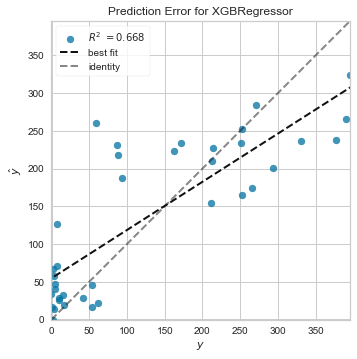

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.05, max_bin=256,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=3, max_leaves=0,
                                 

In [180]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_reg, X_train, y_train, X_test, y_test))


Residuals Plot


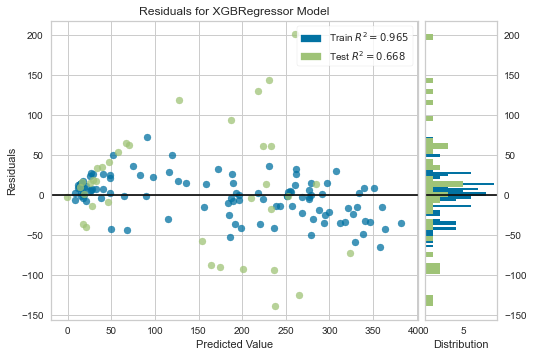

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

In [181]:
# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(xgb_reg, X_train, y_train, X_test, y_test))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

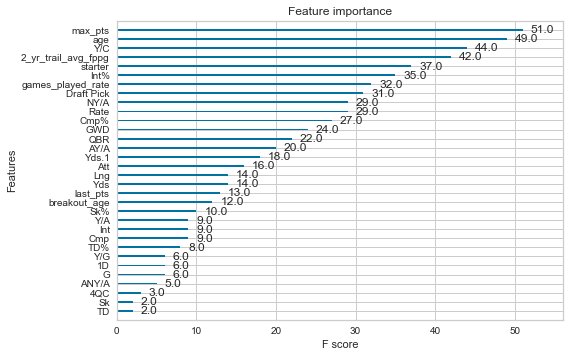

In [182]:
from xgboost import plot_importance

plot_importance(xgb_reg)

## Regularization

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=24, shuffle=True)
lambda_values = [1, 10, 50, 100]
for val in lambda_values:
    xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=100, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, reg_lambda=val)


    xgb_reg.fit(X_train, y_train)

    y_pred = xgb_reg.predict(X_test)
    y_true = y_test

    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)

    R_squared = r2_score(y_true, y_pred)

    print("lambda = ", val)
    print("RMSE: ", np.round(RMSE, 2))
    print("R-Squared: ", np.round(R_squared, 2))
    print()

[22:13:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


lambda =  1
RMSE:  76.12
R-Squared:  0.63

[22:13:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


lambda =  10
RMSE:  78.87
R-Squared:  0.6

[22:13:22] WARNI

#### no regularization needed

In [199]:
# Instantiate an XGBoost object with hyperparameters
xgb_reg2 = xgb.XGBRegressor(max_depth=4, n_estimators=100, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=24, learning_rate=0.1, reg_lambda=50)

In [200]:
xgb_reg2.fit(X_train, y_train,verbose=True)

[22:22:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "objectvie" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, objectvie='reg:squarederror',
             predictor='auto', random_state=24, reg_alpha=0, ...)

In [201]:
y_pred2 = xgb_reg2.predict(X_test) # Predictions
y_true2 = y_test # True values

In [202]:
MSE = mse(y_true2, y_pred2)
RMSE = np.sqrt(MSE)

R_squared = r2_score(y_true2, y_pred2)

print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))


RMSE:  80.54

R-Squared:  0.61



Prediction Error Plot


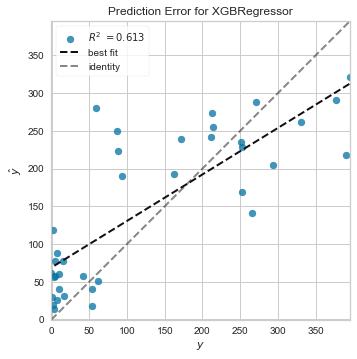

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bynode=1, colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='',
                                       learning_rate=0.1, max_bin=256,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=4, max_leaves=0,
                                  

In [203]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_reg2, X_train, y_train, X_test, y_test))


Residuals Plot


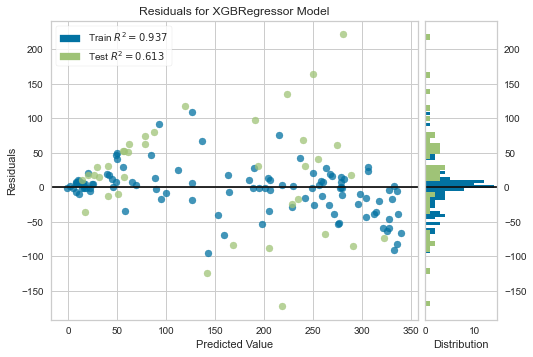

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

In [204]:
# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(xgb_reg2, X_train, y_train, X_test, y_test))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

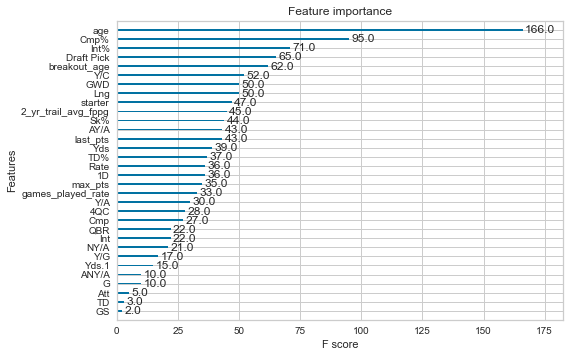

In [205]:
from xgboost import plot_importance

plot_importance(xgb_reg2)

## Score 2022

In [206]:
brady_2022 = pd.DataFrame(xgb_reg2.predict(qb_2022_df_final)).set_index(qb_2022_df['id']).sort_values(0,ascending=False)
brady_2022

,0
id,
Kirk Cousins,320.582642
Aaron Rodgers,318.217255
Russell Wilson,317.567993
Dak Prescott,305.182983
Kyler Murray,303.584869
Jalen Hurts,277.708649
Carson Wentz,265.561646
Jameis Winston,260.805298
Lamar Jackson,258.914185


## Score 2018

In [184]:
qb_2018 = qb_final_df[['Full Name','Age','Team', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                     'Fantasy Points Per Game (2018)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick','Breakout Age',
                       'Rushing Touchdowns (2014)', 
                       'Rushing Touchdowns (2015)','Rushing Touchdowns (2016)','Rushing Touchdowns (2017)',
                       'Rushing Touchdowns (2018)'
                    ]].dropna(subset=['Fantasy Points Per Game (2018)'])

qb_2018_team = pd.read_csv('qb_2018_team.csv').drop(columns=['Unnamed: 0'])

team_2018 = pd.read_csv('brady_input_2018.csv')

qb_2018_final = qb_2018_team.copy()
qb_2018_final

qb_2018_final['y'] = qb_2018_final['fpts_2018']
qb_2018_final['y'].describe()

fpts_df_2018 = qb_2018_final[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]


fppg_df_2018 = qb_2018_final[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                             ]]

games_df_2018 = qb_2018_final[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

df_2018 = qb_2018_final[['y','starter']]

df_2018['age'] = qb_2018_final['Age'] - 4

df_2018['max_pts'] = fpts_df_2018.max(axis=1)

df_2018['last_pts'] = fpts_df_2018['fpts_2017']

df_2018['2_yr_trail_avg_fppg'] = fppg_df_2018[[
                        'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']].mean(axis=1)

df_2018['Draft Pick'] = qb_2018_final['Draft Pick']

df_2018['breakout_age'] = qb_2018_final['Breakout Age']

df_2018['games_played_rate'] = games_df_2018.sum(axis=1)/(games_df_2018.count(axis=1)*16)

df_2018_id = df_2018.copy()
df_2018_id['id'] = qb_2018_final['Full Name']
df_2018_id['year'] = 2018

qb_2018_df = df_2018_id.merge(qb_pf_data_2017, left_on='id',right_on='Player',how='inner')
qb_2018_df

qb_2018_df_final = qb_2018_df.drop(columns=['id','year','Unnamed: 0','Player','Tm','Pos','QBrec','Age'])
qb_2018_df_final

,y,starter,age,max_pts,last_pts,2_yr_trail_avg_fppg,Draft Pick,breakout_age,games_played_rate,G,...,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD
0,0.2,0,27.7,57.4,2.6,1.30,5.24,21.0,0.281250,3,...,22.0,63.4,24.0,1,9,6.7,3.80,3.80,NaN,NaN
1,308.8,1,34.5,382.4,135.8,21.65,1.24,19.8,0.859375,7,...,239.3,97.2,66.0,22,168,8.5,5.80,5.99,2.0,2.0
2,143.0,1,34.1,300.0,300.0,17.60,1.01,19.3,0.953125,15,...,269.5,104.7,65.1,35,207,6.5,7.10,7.65,1.0,3.0
3,185.9,1,30.6,268.8,222.4,15.35,2.03,20.9,0.953125,16,...,207.5,86.6,44.8,39,255,7.3,5.73,5.65,3.0,3.0
4,348.8,1,36.3,305.6,270.0,18.25,1.11,19.5,0.890625,15,...,283.4,93.4,66.6,21,139,3.6,7.07,6.95,3.0,4.0
5,36.8,0,28.6,136.8,65.5,13.10,1.10,19.9,0.312500,5,...,217.2,71.9,34.0,23,149,11.9,4.83,4.06,2.0,2.0
6,184.6,1,26.4,332.8,256.0,16.80,1.03,20.7,0.968750,16,...,230.4,84.7,59.2,24,123,4.4,6.52,6.21,1.0,1.0
7,-0.5,0,32.6,173.8,68.0,10.05,NaN,NaN,0.640625,11,...,117.0,74.5,NaN,16,112,7.0,5.18,4.74,NaN,NaN
8,70.0,0,27.5,184.5,69.0,11.90,2.25,20.8,0.515625,6,...,181.3,72.5,50.2,10,64,5.5,5.63,4.94,NaN,NaN
9,82.0,0,24.5,94.8,94.8,15.80,3.40,21.8,0.375000,7,...,204.3,69.2,35.4,19,141,7.8,5.30,4.52,NaN,NaN


In [185]:
brady_2018 = pd.DataFrame(xgb_reg.predict(qb_2018_df_final.drop(columns=['y']))
                         ).set_index(qb_2018_df['id']).sort_values(0,ascending=False)
brady_2018.reset_index().merge(qb_2018_df[['id','y']], how='left',on='id')

,id,0,y
0,Tom Brady,318.408630,291.2
1,Matthew Stafford,315.274353,222.4
2,Alex Smith,309.097504,143.0
3,Carson Wentz,307.490082,198.0
4,Russell Wilson,307.330261,304.0
5,Drew Brees,299.297150,307.5
6,Philip Rivers,274.607574,286.4
7,Deshaun Watson,266.262634,340.8
8,Jameis Winston,260.227173,210.1
9,Matt Ryan,258.423279,356.8
